## Step 0: Pre-Requirements - Import Modules 

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib
from statsmodels.tools.eval_measures import rmse 
from sklearn.preprocessing import MinMaxScaler
import keras
import tensorflow as tf
from keras.preprocessing.sequence import TimeseriesGenerator
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
import warnings 
warnings.filterwarnings("ignore")

Using matplotlib backend: agg


/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


## Step 1 : Import data set and draw ACF / PACF plot then choose time lag

Download the data from https://github.com/Marimuthu8421/LSTM-Models/tree/main/data/UK and store it in your local file. Run the below code and click 'Choose Files' then browse your data (.csv file). 

In [2]:
from google.colab import files
uploaded = files.upload()

Saving UK covid19 train_data.csv to UK covid19 train_data.csv


Import the uploaded data as name 'df' using the function pd.read_csv(). If you are using other data then please change 'UK covid19 train_data.csv' as data file name.

In [3]:
import pandas as pd
import io
df = pd.read_csv(io.BytesIO(uploaded['UK covid19 train_data.csv']))

# Print variable names
print(list(df.columns))

# Print Head of the data
print(df.head())

['Date', 'Confirmed']
        Date  Confirmed
0  01-May-21       2226
1  02-May-21       1819
2  03-May-21       1429
3  04-May-21       1515
4  05-May-21       2082


In [4]:
# Month  is already in index of df otherwise change it usingthe following code
# change the Month column as Index

df1=df
df1.Date=pd.to_datetime(df.Date)
df1=df1.set_index("Date")
df1.head()

,Confirmed
Date,
2021-05-01,2226
2021-05-02,1819
2021-05-03,1429
2021-05-04,1515
2021-05-05,2082


Plot line graph for Daily cases using the code given below

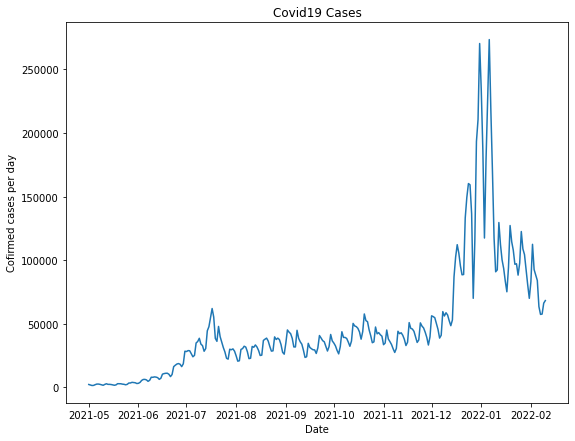

In [5]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(9, 7))
ax.plot(df1.index.values, df1['Confirmed'])
ax.set(xlabel="Date",
       ylabel="Cofirmed cases per day",
       title="Covid19 Cases")

plt.show()

Draw ACF / PACF plot using the function accf() / pacf(). Choose the significant lag as the optimal time step which can be used for data pre-processing.

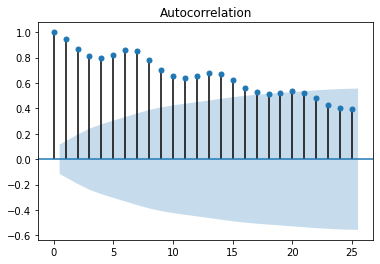

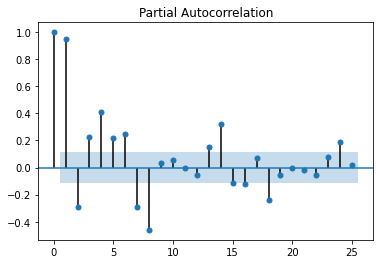

In [6]:
## Auto correlation and Partial Auto correlation Plot
from statsmodels.graphics.tsaplots import acf, pacf, plot_pacf, plot_acf
from matplotlib import pyplot

import numpy as np
dat=np.array(df1['Confirmed'])

plot_acf(dat)
plot_pacf(dat)
pyplot.show()

## Step2: Data pre-processing

We can divide the sequence into input (X) and output (y).
Let {Xi, i=1, 2, 3, …, n} be the daily incident cases. Suppose, lag is three, then the fourth day count depends on previous 3 days (third, second and first) and fifth day count depends on fourth, third, and second day counts, and so on. Therefore, the data should be organized as follows:

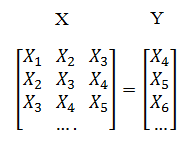

Define the function **prepare_data()** which convert the time series data into X and y.

In [7]:
# preparing independent and dependent features
def split_sequence(sequence, n_step):
	X, y = list(), list()
	for i in range(len(sequence)):
		# find the end of this pattern
		end_ix = i + n_step
		# check if we are beyond the sequence
		if end_ix > len(sequence)-1:
			break
		# gather input and output parts of the pattern
		seq_x, seq_y = sequence[i:end_ix], sequence[end_ix]
		X.append(seq_x)
		y.append(seq_y)
	return np.array(X), np.array(y)

In [8]:
n_step=14 # Choose from the ACF plot

# split into samples
X, y = split_sequence(df['Confirmed'], n_step)

print(X.shape)

(272, 14)


In [9]:
# Summarize the data
for i in range(len(X)):
  print(X[i], y[i])

[2226 1819 1429 1515 2082 2548 2565 2323 1977 1605 2302 2803 2328 2330] 2180
[1819 1429 1515 2082 2548 2565 2323 1977 1605 2302 2803 2328 2330 2180] 1929
[1429 1515 2082 2548 2565 2323 1977 1605 2302 2803 2328 2330 2180 1929] 1624
[1515 2082 2548 2565 2323 1977 1605 2302 2803 2328 2330 2180 1929 1624] 1914
[2082 2548 2565 2323 1977 1605 2302 2803 2328 2330 2180 1929 1624 1914] 2852
[2548 2565 2323 1977 1605 2302 2803 2328 2330 2180 1929 1624 1914 2852] 2809
[2565 2323 1977 1605 2302 2803 2328 2330 2180 1929 1624 1914 2852 2809] 2805
[2323 1977 1605 2302 2803 2328 2330 2180 1929 1624 1914 2852 2809 2805] 2508
[1977 1605 2302 2803 2328 2330 2180 1929 1624 1914 2852 2809 2805 2508] 2364
[1605 2302 2803 2328 2330 2180 1929 1624 1914 2852 2809 2805 2508 2364] 1995
[2302 2803 2328 2330 2180 1929 1624 1914 2852 2809 2805 2508 2364 1995] 2321
[2803 2328 2330 2180 1929 1624 1914 2852 2809 2805 2508 2364 1995 2321] 3360
[2328 2330 2180 1929 1624 1914 2852 2809 2805 2508 2364 1995 2321 3360] 3418

## Step 3: Reorganize the data as in the format of input to the model

CNN LSTM model has one more argument called ‘subsequence’. Split the lag into number of sequence and sub steps. And the sub-steps are multiple of the kernel size in the convolutional layer. For example, lag is six days then split the six into three subsequences and two sub-steps (3*2=6) and the kernel size of the convolutional layer must be two. The input shape of the CNN LSTM model is [samples, subsequences, sub-steps, features]

In [10]:
# reshape from [samples, timesteps] into [samples, timesteps, features]
n_features = 1
n_seq=7
n_steps=2
X = X.reshape((X.shape[0],  n_seq, n_steps, n_features))
print(X.shape)
#print(X)

(272, 7, 2, 1)


## Step 4: Model Buiilding

A CNN model can be used in a hybrid model with an LSTM backend where the CNN is used to interpret subsequences of input that together are provided as a sequence to an LSTM model to interpret. This hybrid model is called a CNN-LSTM.

Our CNN-LSTM model has one 1d-CNN layer followed by max-pooling layer and flatten layer.  Then two LSTM layers with 500 neurons followed by eight dense layers

However, the dense layers can be adjusted based on the model perfomance.

In [11]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten, TimeDistributed
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D

# define model
model = Sequential()
model.add(TimeDistributed(Conv1D(filters=64, kernel_size=1, activation='relu',kernel_initializer='he_uniform',kernel_regularizer =keras.regularizers.l2( l=0.01)), input_shape=(None, n_steps, n_features)))
model.add(TimeDistributed(MaxPooling1D(pool_size=2)))
model.add(TimeDistributed(Flatten()))

model.add(LSTM(500, activation='relu',return_sequences=True,kernel_initializer='he_uniform',kernel_regularizer =keras.regularizers.l2( l=0.01)))
model.add(LSTM(500, activation='relu',kernel_initializer='he_uniform',kernel_regularizer =keras.regularizers.l2( l=0.01)))

#model.add(Dense(5000, activation='relu',kernel_initializer='he_uniform',kernel_regularizer =keras.regularizers.l2( l=0.01)))
#model.add(Dense(3000, activation='relu',kernel_initializer='he_uniform',kernel_regularizer =keras.regularizers.l2( l=0.01)))
#model.add(Dense(2000, activation='relu',kernel_initializer='he_uniform',kernel_regularizer =keras.regularizers.l2( l=0.01)))
model.add(Dense(1000, activation='relu',kernel_initializer='he_uniform',kernel_regularizer =keras.regularizers.l2( l=0.01)))
model.add(Dense(500, activation='relu',kernel_initializer='he_uniform',kernel_regularizer =keras.regularizers.l2( l=0.01)))
model.add(Dense(300, activation='relu',kernel_initializer='he_uniform',kernel_regularizer =keras.regularizers.l2( l=0.01)))
model.add(Dense(200, activation='relu',kernel_initializer='he_uniform',kernel_regularizer =keras.regularizers.l2( l=0.01)))
model.add(Dense(100, activation='relu',kernel_initializer='he_uniform',kernel_regularizer =keras.regularizers.l2( l=0.01)))
model.add(Dense(1))


In [12]:
# Compile the Model
model.compile(optimizer='adam', loss='mse')

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed (TimeDistr  (None, None, 2, 64)      128       
 ibuted)                                                         
                                                                 
 time_distributed_1 (TimeDis  (None, None, 1, 64)      0         
 tributed)                                                       
                                                                 
 time_distributed_2 (TimeDis  (None, None, 64)         0         
 tributed)                                                       
                                                                 
 lstm (LSTM)                 (None, None, 500)         1130000   
                                                                 
 lstm_1 (LSTM)               (None, 500)               2002000   
                                                        

**Call backs**

**reuce lr (Learning Rate)**-if no  improvement seeing for the patience the learning rate is reuce.

**factor** - by which the learning eate will be reduce.

**patience** - # of epochs with no improvement after that the learning rate will reduce

**verbose** - contain binary 0 quit 1 update message.

**mode** - auto min max, 
    **min** - LR will reduce when quantity 
monitor has stop decresing;
    **max** -  LR will reduce when quantity monitor has stop incresing;
    **auto** - the direction is automatically infere from the nameof monitor. 

In [13]:
# Call backs
# reuce lr (Learning Rate)-if no  improvement seeing for the patience the learning rate is reuce
# factor - by which the learning eate will be reduce
# patience - # of epochs with no improvement after that the learning rate will reduce
# verbose - contain binary 0 quit 1 update msg
# mode - auto min max, min - LR will reduce when quantity monitor has stop decresing
#         max -  LR will reduce when quantity monitor has stop incresing
#         auto - the direction is automatically infere from the nameof monitor
# Early stopping  

from keras.callbacks import ModelCheckpoint
from keras.callbacks import ReduceLROnPlateau
from keras.callbacks import EarlyStopping

checkpoint=ModelCheckpoint(filepath='best_weights.hdf11', 
                           save_best_only=True, save_weights_only=True)
lr_reduce=ReduceLROnPlateau(monitor='loss',factor=0.3,
                            patience=3,  verbose=2, mode='max')
early_stop=EarlyStopping(monitor='loss',min_delta=0.1, patience=3, mode='min')

## Step 5: Fitting and evaluating the model

Fit a model using the train data and evaluate the performance. The Mean Squared Error (MSE) / Mean Absolute Error (MAE) can be used as the metrics to evaluate model performance of both train and test data. 

In [ ]:
# fit model

model.fit(X, y, epochs=100,batch_size=32, verbose=1,callbacks=[checkpoint,lr_reduce])

Epoch 1/100
8/8 [==============================] - 4s 185ms/step - loss: 107482275840.0000 - lr: 0.0010
Epoch 2/100
8/8 [==============================] - 1s 185ms/step - loss: 2535363584.0000 - lr: 0.0010
Epoch 3/100
8/8 [==============================] - 1s 176ms/step - loss: 1117548672.0000 - lr: 0.0010
Epoch 4/100
8/8 [==============================] - ETA: 0s - loss: 1210281984.0000WARNING:tensorflow:Can save best model only with val_loss available, skipping.

Epoch 00004: ReduceLROnPlateau reducing learning rate to 0.0003000000142492354.
8/8 [==============================] - 1s 174ms/step - loss: 1210281984.0000 - lr: 0.0010
Epoch 5/100
8/8 [==============================] - 1s 174ms/step - loss: 658534592.0000 - lr: 3.0000e-04
Epoch 6/100
8/8 [==============================] - 1s 177ms/step - loss: 287807904.0000 - lr: 3.0000e-04
Epoch 7/100
8/8 [==============================] - ETA: 0s - loss: 166161824.0000WARNING:tensorflow:Can save best model only with val_loss available, 

In [ ]:
# Predict the data for training data set.

y_hat=model.predict(X, verbose=1)
print(y_hat)

8/8 [==============================] - 1s 44ms/step
[[  2248.331 ]
 [  2173.6682]
 [  2240.064 ]
 [  2072.6653]
 [  2012.0624]
 [  1463.2019]
 [  1225.7349]
 [  2756.4778]
 [  1680.5253]
 [  2142.54  ]
 [  2110.1882]
 [  1920.5366]
 [  1854.763 ]
 [  2374.4531]
 [  3259.6782]
 [  2532.5305]
 [  2815.8494]
 [  2777.173 ]
 [  2735.213 ]
 [  3266.7244]
 [  3559.3982]
 [  4948.672 ]
 [  5019.53  ]
 [  5221.744 ]
 [  4825.1523]
 [  5678.6514]
 [  5259.906 ]
 [  6097.0537]
 [  7093.9033]
 [  7739.045 ]
 [  8181.4697]
 [  7469.9814]
 [  7852.121 ]
 [  6965.258 ]
 [  7422.5645]
 [  7987.1167]
 [ 11839.494 ]
 [  9882.438 ]
 [ 10390.995 ]
 [ 10377.36  ]
 [ 10363.312 ]
 [ 14292.634 ]
 [ 14262.814 ]
 [ 14935.486 ]
 [ 16362.412 ]
 [ 19880.459 ]
 [ 21877.307 ]
 [ 19458.324 ]
 [ 20719.844 ]
 [ 23053.623 ]
 [ 24962.709 ]
 [ 28047.105 ]
 [ 26445.348 ]
 [ 24347.408 ]
 [ 25283.744 ]
 [ 27370.416 ]
 [ 24878.69  ]
 [ 31864.176 ]
 [ 31068.63  ]
 [ 33377.97  ]
 [ 33870.03  ]
 [ 29240.34  ]
 [ 32513.877 ]
 [ 

In [ ]:
# Merge the predicted data with the data set

n_steps=14
df_pred=pd.DataFrame.from_records(y_hat, columns=['Predicted'])
df_pred=df_pred.reset_index(drop=True)


df_actual= pd.DataFrame(dat[n_steps:len(dat)], columns=['Actual'])
df_actual=df_actual.reset_index(drop=True)


Date=df.iloc[n_steps:,0]
Date=Date.reset_index(drop=True)

data=pd.concat ([Date,df_actual,df_pred],axis=1)

print(data)

     Actual
0      2193
1      2027
2      1926
3      1979
4     -2364
..      ...
243  129544
244  105679
245   98578
246   80725
247   70160

[248 rows x 1 columns]
<class 'pandas.core.frame.DataFrame'>
(248, 3)
     Days  Actual      Predicted
0      15    2193    2248.331055
1      16    2027    2173.668213
2      17    1926    2240.063965
3      18    1979    2072.665283
4      19   -2364    2012.062378
..    ...     ...            ...
243   258  129544  116649.585938
244   259  105679   96542.703125
245   260   98578  131440.625000
246   261   80725  105739.789062
247   262   70160   72251.359375

[248 rows x 3 columns]


**Evaluation Metrics for traning data set.**

In [ ]:
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

R2=r2_score(df_actual, df_pred)
print('R Squared: ', R2)

mae=mean_absolute_error(df_actual, df_pred)
print('Mean Absolute Error: ', mae)

mse=mean_squared_error(df_actual, df_pred)
print('Mean Squared Error: ', mse)

R Squared:  0.9258081028158568
Mean Absolute Error:  6410.925453432144
Mean Squared Error:  113962674.37004818


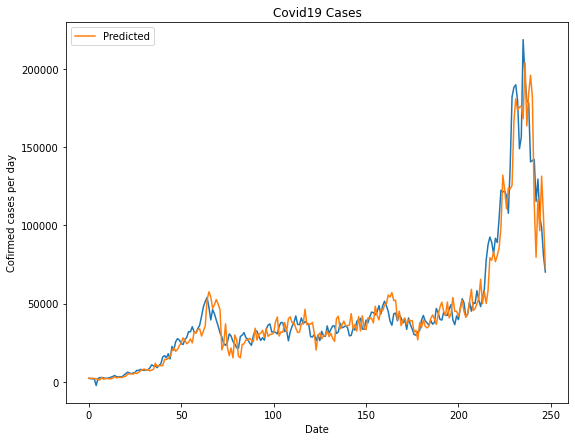

In [ ]:
# Plot the observed and predicted cases

fig, ax = plt.subplots(figsize=(9, 7))
ax.plot(data.index.values, data['Actual'])
data.Predicted.plot(ax=ax)
ax.set(xlabel="Date",
       ylabel="Cofirmed cases per day",
       title="Covid19 Cases")
plt.legend()
plt.show()

In [ ]:
import datetime
from datetime import datetime, timedelta, date
last_date=df.iloc[-1,0]

predictions=model.predict(X,verbose=1)

# Length of future day you wanted to predict
future_time_steps=30
x1=X[-1:,:,:,:] # Last input
x1=x1.astype('float64')

p1=predictions[-1:]  # take last output

for i  in range(future_time_steps):
  #x2=np.array([[x1[0][0][1][0], x1[0][1][0][0], x1[0][1][1][0], x1[0][2][0][0], x1[0][2][1][0], x1[0][3][0][0], 
  #    x1[0][3][1][0], x1[0][4][0][0], x1[0][4][1][0], x1[0][5][0][0], x1[0][5][1][0], p1]] ,dtype=np.float)
  x2=np.array([[x1[0][0][1][0], x1[0][1][0][0], x1[0][1][1][0], x1[0][2][0][0], x1[0][2][1][0], x1[0][3][0][0], x1[0][3][1][0],
       x1[0][4][0][0], x1[0][4][1][0], x1[0][5][0][0], x1[0][5][1][0], x1[0][6][0][0], x1[0][6][1][0], p1]] ,dtype=np.float)
  
  
  print('X2 is', x2)
  x3=x2.reshape((1,7,2,1))

  p2=model.predict(x3, verbose=1)
  predictions=np.append(predictions, p2)
  x1=x3
  p1=p2

yhat=predictions
yhat=np.reshape(yhat, (-1,1))

df_pred=pd.DataFrame.from_records(yhat, columns=['Predicted'])
df_pred=df_pred.reset_index(drop=True)

df_actual=df[n_steps:len(df)]
df_actual=df_actual.reset_index(drop=True)

In [ ]:
# Concatinate the predicted data with observed data

Predicted_data=pd.concat ([df_actual,df_pred],axis=1)

print(type(Predicted_data))
print(Predicted_data.shape)
print(Predicted_data)

<class 'pandas.core.frame.DataFrame'>
(278, 5)
     Days       Date  Confirmed  Cumulative_cases     Predicted
0    15.0 2021-05-15     2193.0         4446828.0   2248.331055
1    16.0 2021-05-16     2027.0         4448855.0   2173.668213
2    17.0 2021-05-17     1926.0         4450781.0   2240.063965
3    18.0 2021-05-18     1979.0         4452760.0   2072.665283
4    19.0 2021-05-19    -2364.0         4450396.0   2012.062378
..    ...        ...        ...               ...           ...
273   NaN        NaT        NaN               NaN  65748.796875
274   NaN        NaT        NaN               NaN  70053.546875
275   NaN        NaT        NaN               NaN  70791.007812
276   NaN        NaT        NaN               NaN  56930.847656
277   NaN        NaT        NaN               NaN  62351.980469

[278 rows x 5 columns]


## Step 7: Download the data

Write the Predicted data as .csv file and download it  for future purpose

In [ ]:
from google.colab import files
Predicted_data.to_csv('UK -COVID-19 Prediction -CNN LSTM 22Jan22.csv') 
files.download('UK -COVID-19 Prediction -CNN LSTM 22Jan22.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>